In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
%matplotlib inline
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt                                        
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam

In [3]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices("GPU")
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0],True) 
    logical_devices = tf.config.list_logical_devices("GPU")
    
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
class_names = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','near-full','none']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (128, 128)

In [5]:
def load_data():
    datasets = ['train', 'test','val']#資料夾
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        x = []
        y = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                #cv讀照片，顏色莫認為BGR，需轉為RGB，錯誤表示黑白或已轉
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                x.append(image)
                y.append(label)
                
        x = np.array(x, dtype = 'float32')
        y = np.array(y, dtype = 'int32')   
        
        output.append((x, y))

    return output
#%%
(x_train, y_train), (x_test, y_test), (x_val, y_val)= load_data()
#%%

Loading train


100%|██████████████████████████████████████████████████████████████████████████████| 835/835 [00:00<00:00, 1035.75it/s]


Loading test


100%|██████████████████████████████████████████████████████████████████████████████| 239/239 [00:00<00:00, 1551.60it/s]


Loading val


100%|██████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 1713.89it/s]


In [6]:
num_classes = 8
input_shape = (128, 128, 3)

#(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - x_test shape: {x_test.shape}- x_val shape: {x_val.shape}")
print(f"y_train shape: {y_train.shape} - y_test shape: {y_test.shape}- y_val shape: {y_val.shape}")

x_train shape: (13180, 128, 128, 3) - x_test shape: (3768, 128, 128, 3)- x_val shape: (1887, 128, 128, 3)
y_train shape: (13180,) - y_test shape: (3768,)- y_val shape: (1887,)


In [7]:
learning_rate = 0.0001
weight_decay = 0.0001
batch_size = 64
num_epochs = 300
image_size = 128  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [9]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [10]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 128 X 128
Patch size: 16 X 16
Patches per image: 64
Elements per patch: 768


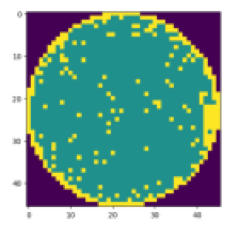

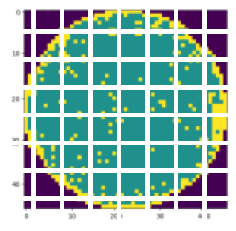

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [12]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [13]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [14]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(8, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_val,y_val),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/300
206/206 [==============================] - 36s 145ms/step - loss: 1.3856 - accuracy: 0.5963 - top-5-accuracy: 1.0000 - val_loss: 0.6601 - val_accuracy: 0.7387 - val_top-5-accuracy: 1.0000
Epoch 2/300
206/206 [==============================] - 28s 136ms/step - loss: 0.7862 - accuracy: 0.7203 - top-5-accuracy: 1.0000 - val_loss: 0.5349 - val_accuracy: 0.7848 - val_top-5-accuracy: 1.0000
Epoch 3/300
206/206 [==============================] - 28s 135ms/step - loss: 0.6230 - accuracy: 0.7698 - top-5-accuracy: 1.0000 - val_loss: 0.4640 - val_accuracy: 0.8235 - val_top-5-accuracy: 1.0000
Epoch 4/300
206/206 [==============================] - 28s 135ms/step - loss: 0.5437 - accuracy: 0.7942 - top-5-accuracy: 1.0000 - val_loss: 0.4126 - val_accuracy: 0.8378 - val_top-5-accuracy: 1.0000
Epoch 5/300
206/206 [==============================] - 28s 137ms/step - loss: 0.4862 - accuracy: 0.8122 - top-5-accuracy: 1.0000 - val_loss: 0.4251 - val_accuracy: 0.8352 - val_top-5-accuracy: 1.0000


Epoch 42/300
206/206 [==============================] - 30s 143ms/step - loss: 0.1640 - accuracy: 0.9401 - top-5-accuracy: 1.0000 - val_loss: 0.1588 - val_accuracy: 0.9433 - val_top-5-accuracy: 1.0000
Epoch 43/300
206/206 [==============================] - 29s 143ms/step - loss: 0.1641 - accuracy: 0.9386 - top-5-accuracy: 1.0000 - val_loss: 0.1940 - val_accuracy: 0.9295 - val_top-5-accuracy: 1.0000
Epoch 44/300
206/206 [==============================] - 30s 145ms/step - loss: 0.1634 - accuracy: 0.9384 - top-5-accuracy: 1.0000 - val_loss: 0.1542 - val_accuracy: 0.9486 - val_top-5-accuracy: 1.0000
Epoch 45/300
206/206 [==============================] - 29s 143ms/step - loss: 0.1572 - accuracy: 0.9419 - top-5-accuracy: 1.0000 - val_loss: 0.1528 - val_accuracy: 0.9465 - val_top-5-accuracy: 1.0000
Epoch 46/300
206/206 [==============================] - 29s 141ms/step - loss: 0.1555 - accuracy: 0.9416 - top-5-accuracy: 1.0000 - val_loss: 0.1555 - val_accuracy: 0.9444 - val_top-5-accuracy: 1.

Epoch 83/300
206/206 [==============================] - 28s 136ms/step - loss: 0.1440 - accuracy: 0.9454 - top-5-accuracy: 1.0000 - val_loss: 0.1526 - val_accuracy: 0.9438 - val_top-5-accuracy: 1.0000
Epoch 84/300
206/206 [==============================] - 29s 140ms/step - loss: 0.1504 - accuracy: 0.9433 - top-5-accuracy: 1.0000 - val_loss: 0.1495 - val_accuracy: 0.9486 - val_top-5-accuracy: 1.0000
Epoch 85/300
206/206 [==============================] - 29s 141ms/step - loss: 0.1528 - accuracy: 0.9420 - top-5-accuracy: 1.0000 - val_loss: 0.1556 - val_accuracy: 0.9422 - val_top-5-accuracy: 1.0000
Epoch 86/300
206/206 [==============================] - 29s 141ms/step - loss: 0.1410 - accuracy: 0.9482 - top-5-accuracy: 1.0000 - val_loss: 0.1460 - val_accuracy: 0.9428 - val_top-5-accuracy: 1.0000
Epoch 87/300
206/206 [==============================] - 29s 141ms/step - loss: 0.1458 - accuracy: 0.9445 - top-5-accuracy: 1.0000 - val_loss: 0.1487 - val_accuracy: 0.9428 - val_top-5-accuracy: 1.

Epoch 124/300
206/206 [==============================] - 29s 142ms/step - loss: 0.1478 - accuracy: 0.9446 - top-5-accuracy: 1.0000 - val_loss: 0.1458 - val_accuracy: 0.9454 - val_top-5-accuracy: 1.0000
Epoch 125/300
206/206 [==============================] - 29s 141ms/step - loss: 0.1482 - accuracy: 0.9442 - top-5-accuracy: 1.0000 - val_loss: 0.1485 - val_accuracy: 0.9444 - val_top-5-accuracy: 1.0000
Epoch 126/300
206/206 [==============================] - 29s 141ms/step - loss: 0.1499 - accuracy: 0.9445 - top-5-accuracy: 1.0000 - val_loss: 0.1539 - val_accuracy: 0.9449 - val_top-5-accuracy: 1.0000
Epoch 127/300
206/206 [==============================] - 30s 143ms/step - loss: 0.1512 - accuracy: 0.9434 - top-5-accuracy: 1.0000 - val_loss: 0.1590 - val_accuracy: 0.9369 - val_top-5-accuracy: 1.0000
Epoch 128/300
206/206 [==============================] - 29s 143ms/step - loss: 0.1523 - accuracy: 0.9433 - top-5-accuracy: 1.0000 - val_loss: 0.1404 - val_accuracy: 0.9486 - val_top-5-accurac

Epoch 205/300
206/206 [==============================] - 29s 140ms/step - loss: 0.1527 - accuracy: 0.9422 - top-5-accuracy: 1.0000 - val_loss: 0.1523 - val_accuracy: 0.9433 - val_top-5-accuracy: 1.0000
Epoch 206/300
206/206 [==============================] - 29s 139ms/step - loss: 0.1533 - accuracy: 0.9423 - top-5-accuracy: 1.0000 - val_loss: 0.1452 - val_accuracy: 0.9470 - val_top-5-accuracy: 1.0000
Epoch 207/300
206/206 [==============================] - 29s 139ms/step - loss: 0.1555 - accuracy: 0.9436 - top-5-accuracy: 1.0000 - val_loss: 0.1670 - val_accuracy: 0.9369 - val_top-5-accuracy: 1.0000
Epoch 208/300
206/206 [==============================] - 29s 139ms/step - loss: 0.1521 - accuracy: 0.9416 - top-5-accuracy: 1.0000 - val_loss: 0.1569 - val_accuracy: 0.9353 - val_top-5-accuracy: 1.0000
Epoch 209/300
206/206 [==============================] - 29s 139ms/step - loss: 0.1564 - accuracy: 0.9404 - top-5-accuracy: 1.0000 - val_loss: 0.1770 - val_accuracy: 0.9316 - val_top-5-accurac

Epoch 286/300
206/206 [==============================] - 28s 138ms/step - loss: 0.1538 - accuracy: 0.9403 - top-5-accuracy: 1.0000 - val_loss: 0.1369 - val_accuracy: 0.9481 - val_top-5-accuracy: 1.0000
Epoch 287/300
206/206 [==============================] - 28s 138ms/step - loss: 0.1512 - accuracy: 0.9427 - top-5-accuracy: 1.0000 - val_loss: 0.1504 - val_accuracy: 0.9438 - val_top-5-accuracy: 1.0000
Epoch 288/300
206/206 [==============================] - 28s 138ms/step - loss: 0.1565 - accuracy: 0.9395 - top-5-accuracy: 1.0000 - val_loss: 0.1691 - val_accuracy: 0.9375 - val_top-5-accuracy: 1.0000
Epoch 289/300
206/206 [==============================] - 28s 138ms/step - loss: 0.1585 - accuracy: 0.9425 - top-5-accuracy: 1.0000 - val_loss: 0.1518 - val_accuracy: 0.9433 - val_top-5-accuracy: 1.0000
Epoch 290/300
206/206 [==============================] - 28s 138ms/step - loss: 0.1492 - accuracy: 0.9443 - top-5-accuracy: 1.0000 - val_loss: 0.1480 - val_accuracy: 0.9459 - val_top-5-accurac

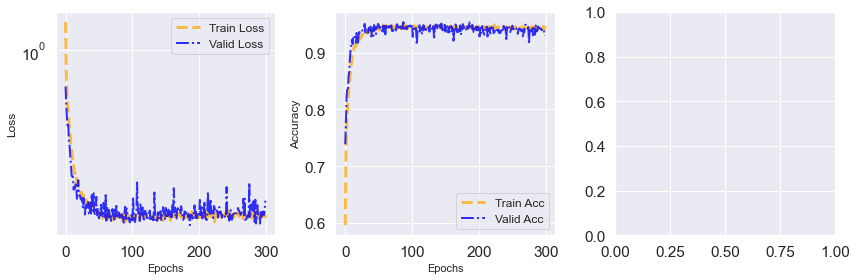

In [23]:
### Plot train and validation curves
loss = history.history['loss']
v_loss = history.history['val_loss']

acc = history.history['accuracy'] 
v_acc = history.history['val_accuracy']

#top5_acc = history.history['top5 acc']
#val_top5_acc = history.history['val_top5 acc']
epochs = range(len(loss))

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.yscale('log')
plt.plot(epochs, loss, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Loss')
plt.plot(epochs, v_loss, linestyle='-.', linewidth=2, color='blue', alpha=0.8, label='Valid Loss')
# plt.ylim(0.3, 100)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 3, 2)
plt.plot(epochs, acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Acc')
plt.plot(epochs, v_acc, linestyle='-.', linewidth=2, color='blue', alpha=0.8, label='Valid Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 3, 3)
#plt.plot(epochs, top5_acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Top 5 Acc')
#plt.plot(epochs, val_top5_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Top5 Acc') 
#plt.xlabel('Epochs', fontsize=11)
#plt.ylabel('Top5 Accuracy', fontsize=12)
#plt.legend(fontsize=12)
plt.tight_layout()
# plt.savefig('/content/gdrive/My Drive/Colab Notebooks/resnet/train_acc.png', dpi=250)
plt.show()

In [16]:
prt = vit_classifier.predict(x_test)

118/118 [==============================] - 4s 26ms/step


In [17]:
prt = np.argmax(prt, axis=1)

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

class_types = class_names

def conf_matrix(predictions): 
    ''' Plots conf. matrix and classification report '''
    cm=confusion_matrix(y_test, np.argmax(np.round(predictions), axis=1))
    print("Classification Report:\n")
    cr=classification_report(y_test,
                                np.argmax(np.round(predictions), axis=1), 
                                target_names=[class_types[i] for i in range(len(class_types))])
    print(cr)
    plt.figure(figsize=(12,12))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels = [class_types[i] for i in range(len(class_types))], 
                yticklabels = [class_types[i] for i in range(len(class_types))], fmt="d")
    fig = sns_hmp.get_figure()
    # fig.savefig('/content/gdrive/My Drive/Colab Notebooks/resnet/heatmap.png', dpi=250)

118/118 [==============================] - 2s 21ms/step
Classification Report:

              precision    recall  f1-score   support

      Center       0.97      0.99      0.98       693
       Donut       0.86      0.96      0.91       111
    Edge-Loc       0.81      0.97      0.88       486
   Edge-Ring       1.00      0.97      0.99      1711
         Loc       0.88      0.78      0.82       325
      Random       0.97      0.90      0.93       173
     Scratch       0.91      0.79      0.85       239
   near-full       0.91      0.97      0.94        30

    accuracy                           0.94      3768
   macro avg       0.91      0.92      0.91      3768
weighted avg       0.95      0.94      0.94      3768



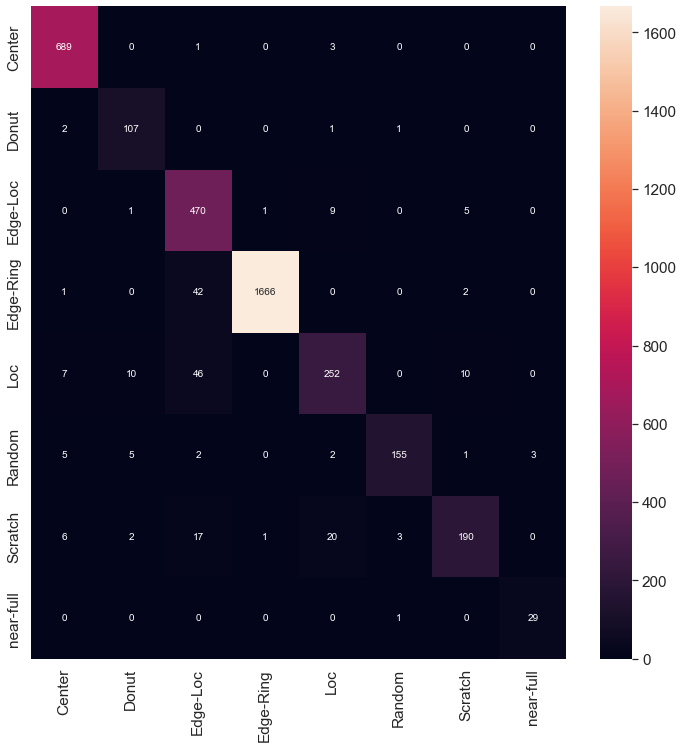

In [19]:
pred_class = vit_classifier.predict(x_test)

conf_matrix(pred_class)

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,prt)

array([[ 685,    1,    2,    0,    3,    0,    2,    0],
       [   2,  106,    0,    0,    1,    2,    0,    0],
       [   0,    1,  469,    1,   10,    0,    5,    0],
       [   1,    0,   33, 1675,    0,    0,    2,    0],
       [   6,    8,   36,    0,  262,    1,   12,    0],
       [   4,    4,    2,    0,    3,  156,    1,    3],
       [   6,    1,   13,    1,   12,    3,  203,    0],
       [   0,    0,    0,    0,    0,    1,    0,   29]], dtype=int64)